# Build the parent sample of large (LSLGA) galaxies.

The purpose of this notebook is to build the parent sample of galaxies in the Legacy Surveys Galaxy Atlas (LSGA).  

The input file is
  * \$LSLGA_DIR/sample/hyperleda-d25min10-18may13.fits

and the final output files are:
  * \$LSLGA_DIR/sample/LSLGA-VERSION.fits -- parent sample of large galaxies   
  * \$LSLGA_DIR/sample/LSLGA-VERSION.kd.fits -- like the preceding catalog but with a pre-built KD tree 
  * \$LSLGA_DIR/sample/LSLGA-VERSION-DRSUFFIX.fits -- large galaxies in the specified data release footprint

where *VERSION* is specified in *LSLGA.io.parent_version* and *DRSUFFIX* is specified below. 

### Imports and other preliminaries.

In [1]:
import os, sys
import time
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma

In [3]:
import LSLGA.io
import LSLGA.match
from legacypipe.survey import LegacySurveyData

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [6]:
drsuffix = 'dr6-dr7'

#### Some choices.

In [8]:
rebuild_parent = False
rebuild_dr_sample = True

### Build the parent sample.

The parent sample is defined as the set of galaxies in the full Hyperleda catalog with a finite magnitude estimate.  (Visually investigating the objects without magnitude estimates reveals that the overwhelming majority are spurious.)

There is also an option here to apply minimum and maximum angular diameter cuts, but in detail we do not apply any.

In addition, to flag galaxies near bright stars; a particularly nice example (that we do not want to throw out!) is [IC 2204](http://legacysurvey.org/viewer?ra=115.3331&dec=34.2240&zoom=12&layer=mzls+bass-dr6), a beautiful r=13.4 disk galaxy at a redshift of z=0.0155 with an angular diameter of approximately 1.1 arcmin.

Finally, we flag galaxies within the (current) DESI footprint.

In [9]:
def build_parent(mindiameter=10/60, maxdiameter=1e4):
    """Build the parent catalog.
    
    """
    import desimodel.io
    import desimodel.footprint
    from astrometry.libkd.spherematch import tree_build_radec, tree_search_radec

    # Read the Hyperleda catalog.
    leda = LSLGA.io.read_hyperleda(verbose=True)
    magcut = np.isfinite( leda['mag'] )
    leda = leda[magcut]
    print('  Removed {}/{} ({:.2f}%) objects with no magnitude estimate.'.format(
        np.sum(~magcut), len(leda), 100*np.sum(~magcut)/len(leda)))
    
    # Flag galaxies in the DESI footprint.
    tiles = desimodel.io.load_tiles(onlydesi=True)
    indesi = desimodel.footprint.is_point_in_desi(tiles, ma.getdata(leda['ra']), 
                                                  ma.getdata(leda['dec']))
    print('  Identified {} ({}) objects inside (outside) the DESI footprint.'.format(
        np.sum(indesi), np.sum(~indesi)))

    diamcut = (leda['d25'] >= mindiameter) * (leda['d25'] <= maxdiameter)
    print('  Removed {}/{} ({:.2f}%) objects with D(25) < {:.3f} and D(25) > {:.3f} arcmin.'.format(
        np.sum(~diamcut), len(leda), 100*np.sum(~diamcut)/len(leda), mindiameter, maxdiameter))

    # Reject objects classified as "g"
    # objnotg = np.hstack([np.char.strip(obj) != 'g' for obj in leda['objtype']])
    # print('  Removed {} objects with objtype == g'.format(np.sum(~objnotg)), flush=True)

    keep = np.where( diamcut )[0]
    #keep = np.where( indesi * diamcut )[0]
    parent = leda[keep]
    parent['in_desi'] = indesi.astype(bool)
    
    # Flag galaxies near bright stars.
    tycho = LSLGA.io.read_tycho(verbose=True)
    kdparent = tree_build_radec(parent['ra'], parent['dec'])

    nearstar = np.zeros( len(parent), dtype=bool)
    for star in tycho:
        I = tree_search_radec(kdparent, star['ra'], star['dec'], star['radius'])
        if len(I) > 0:
            nearstar[I] = True
    print('  Found {}/{} ({:.2f}%) galaxies near a Tycho-2 star.'.format(
        np.sum(nearstar), len(leda), 100*np.sum(nearstar)/len(leda)))
    parent['near_brightstar'] = nearstar.astype(bool)

    parentfile = LSLGA.io.get_parentfile()    
    kdparentfile = LSLGA.io.get_parentfile(kd=True)

    print('Writing {} objects to {}'.format(len(parent), parentfile))
    parent.write(parentfile, overwrite=True)

    print()
    print('Writing {}'.format(kdparentfile))
    cmd = 'startree -i {} -o {} -T -P -k -n largegals'.format(parentfile, kdparentfile)
    print(cmd)
    _ = os.system(cmd)    

In [10]:
if rebuild_parent:
    %time build_parent()

In [11]:
parent, kdparent = LSLGA.io.read_parent(verbose=True), LSLGA.io.read_parent(kd=True, verbose=True)
parent

Read 1363748 galaxies from /global/cscratch1/sd/ioannis/LSLGA/sample/LSLGA-v1.0.fits
Read 1363748 galaxies from KD catalog /global/cscratch1/sd/ioannis/LSLGA/sample/LSLGA-v1.0.kd.fits


galaxy,pgc,objtype,ra,dec,type,bar,ring,multiple,compactness,t,d25,ba,pa,bt,it,kt,modbest,z,sb_d25,mag,groupid,designation,wise_ra,wise_dec,cntr,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,w4mpro,w4sigmpro,nb,na,cc_flags,ext_flg,ph_qual,w1mag,w1sigm,w2mag,w2sigm,w3mag,w3sigm,w4mag,w4sigm,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,inwise,in_desi,near_brightstar
bytes28,int64,bytes2,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,bool,bool,bool
PGC639648,639648,G,0.0003765,-36.1988588,nan,nan,nan,nan,nan,nan,0.213796,0.891251,100.0,18.58,nan,nan,nan,nan,23.8585,18.58,0,J000000.04-361155.2,0.0001762,-36.1986875,36401351031683,15.624,0.039,15.286,0.074,11.441,0.138,8.682,nan,1,0,0000,0,AABU,15.33,0.031,15.044,0.079,11.375,0.14,8.626,0.359,0,nan,nan,nan,nan,nan,nan,True,False,False
PGC622563,622563,G,0.000474,-37.4760687,nan,nan,nan,nan,nan,nan,0.295121,0.758578,128.0,17.75,15.835,13.442,nan,nan,23.7285,17.75,0,J000000.11-372834.6,0.0004772,-37.4762838,37901351043221,13.59,0.025,13.489,0.03,12.717,0.436,9.121,nan,1,0,0000,1,AACU,13.333,0.011,13.24,0.022,12.184,0.427,8.64,nan,555089782,15.626,0.101,14.775,0.096,14.377,0.093,True,False,False
PGC1982072,1982072,G,0.000603,32.1365967,nan,nan,nan,nan,nan,nan,0.323594,0.74131,136.5,17.78,nan,13.728,nan,nan,23.9585,17.78,0,J000000.08+320811.7,0.0003588,32.1366072,131801351041012,13.953,0.027,13.699,0.034,9.883,0.047,7.525,0.126,1,0,d000,1,AAAB,13.711,0.016,13.506,0.03,9.725,0.046,7.504,0.18,338226820,15.945,0.096,15.256,0.127,14.795,0.135,True,True,False
PGC535833,535833,G,0.00066,-44.577893,nan,nan,nan,nan,nan,nan,0.334965,0.582103,148.5,17.63,17.135,nan,nan,nan,23.8835,17.63,0,J000000.15-443440.8,0.0006345,-44.5780196,44001351005367,15.497,0.041,15.269,0.083,12.006,0.318,8.353,nan,1,0,0000,0,AABU,15.224,0.044,15.093,0.139,11.777,0.286,8.074,nan,0,nan,nan,nan,nan,nan,nan,True,False,False
SDSSJ000000.16-001108.5,4165833,G,0.000702,-0.1857632,nan,nan,nan,nan,nan,nan,0.180717,0.907821,nan,18.873,17.503,nan,39.84,0.195055,23.7865,18.873,0,J000000.16-001108.6,0.0007006,-0.18574,100001351018364,14.58,0.032,13.951,0.042,10.355,0.075,8.014,0.252,1,0,0000,0,AAAB,14.52,0.056,13.896,0.052,10.357,0.11,7.693,nan,0,nan,nan,nan,nan,nan,nan,True,True,False
PGC520795,520795,G,0.0007365,-45.9540486,nan,nan,nan,nan,nan,nan,0.338844,0.668344,24.68,17.54,15.5,13.341,nan,nan,23.8185,17.54,0,J000000.14-455715.2,0.0005894,-45.9542465,45501351005362,13.482,0.024,13.31,0.03,12.317,0.43,8.655,nan,1,0,0000,1,AACU,13.226,0.011,13.066,0.032,12.014,0.364,8.294,nan,572925716,15.409,0.086,14.683,0.09,14.122,0.086,True,False,False
PGC1961515,1961515,G,0.000762,31.7311001,nan,nan,nan,nan,nan,nan,0.39355,0.609537,160.33,17.38,nan,13.47,nan,nan,23.9835,17.38,0,J000000.15+314351.3,0.0006609,31.7309335,131801351028798,14.018,0.039,13.906,0.049,10.515,0.098,8.475,0.503,2,1,0000,4,AAAC,13.346,0.015,13.268,0.029,9.894,0.058,8.404,0.424,338227585,15.632,0.089,15.001,0.112,14.616,0.129,True,True,True
PGC228194,228194,G,0.0009555,-80.2419449,nan,nan,nan,nan,nan,nan,0.331131,0.707946,175.0,17.78,15.61,13.455,nan,nan,24.0085,17.78,0,J000000.13-801430.8,0.0005599,-80.2418934,80301351031314,13.433,0.024,13.266,0.025,10.543,0.061,8.612,0.306,1,0,0000,5,AAAB,13.266,0.008,13.104,0.02,10.346,0.057,8.084,nan,718175333,15.536,0.084,14.633,0.116,14.37,0.097,True,False,False
PGC124374,124374,G,0.0012825,-41.4229345,nan,nan,nan,nan,nan,nan,0.37325,0.952796,nan,16.98,15.05,13.25,37.165,0.06167,23.4685,16.98,0,J000000.28-412522.3,0.0011826,-41.4228663,40901351005636,13.266,0.025,13.259,0.029,12.201,nan,9.098,nan,1,0,d000,1,AAUU,13.058,0.008,13.053,0.02,11.925,nan,8.116,

#### Some sanity QA.

In [12]:
def qa_mag_d25():
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hexbin(parent['mag'], np.log10(parent['d25']), extent=(0, 25, -1, 3),
              mincnt=1, cmap='viridis')
    ax.axhline(y=np.log10(10 / 60), ls='-', lw=2, color='k', alpha=0.8)
    ax.set_xlabel('B mag')
    ax.set_ylabel(r'$\log_{10}\, D_{25}$ (arcmin)')

In [13]:
def qa_radec_parent():
    indesi = parent['in_desi']
    outdesi = ~indesi
    nearstar = parent['near_brightstar']

    fig, ax = plt.subplots()
    ax.scatter(parent['ra'][outdesi], parent['dec'][outdesi], s=5, label='Outside DESI')
    ax.scatter(parent['ra'][indesi], parent['dec'][indesi], s=5, label='In DESI')
    ax.scatter(parent['ra'][nearstar], parent['dec'][nearstar], 
               s=1, color='k', label='Near Bright Star')
    #ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR7')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.set_xlim(360, 0)
    ax.set_ylim(-90, 120)
    ax.legend(loc='upper left', fontsize=10, frameon=True, ncol=3)

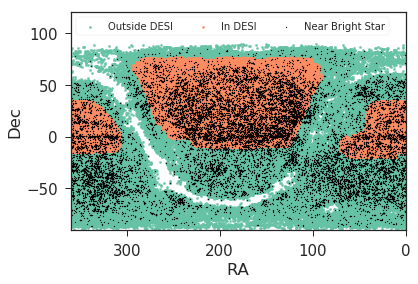

In [14]:
qa_radec_parent()

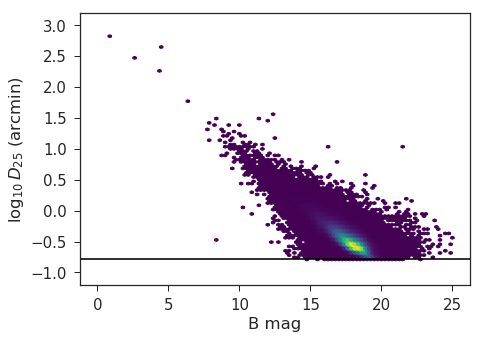

In [15]:
qa_mag_d25()

In [16]:
# This fails because of a matplotlib, basemap collision.
#from LSLGA.qa import qa_binned_radec
#qa_binned_radec(parent)

### Find the sample of galaxies in the DR6/DR7 footprint.

In [17]:
survey_dr6 = LegacySurveyData(survey_dir='/global/cscratch1/sd/dstn/dr6plus')
survey_dr7 = LegacySurveyData(survey_dir='/global/cscratch1/sd/desiproc/dr7')

In [18]:
def _build_drsample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_drsample_one(*args)

In [19]:
def build_drsample_one(onegal, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a single galaxy.
    
    """
    diam = 1.0 * onegal['d25'] # [arcmin]
    wcs = LSLGA.match.simple_wcs(onegal, diam)
    
    ccds = survey_dr7.ccds_touching_wcs(wcs, ccdrad=None)
    if ccds is not None:
        dr = 'dr7'
        survey = survey_dr7
    else:
        ccds = survey_dr6.ccds_touching_wcs(wcs, ccdrad=None)
        if ccds is not None:
            dr = 'dr6'
            survey = survey_dr6
        else:
            return [None, None]
        
    if ccds is not None:
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            nccd = len(ccds)
            ccds.galaxy_npix = np.zeros(nccd).astype('int') # number of pixels in cutout
            ccds.galaxy_fracsatur = np.zeros(nccd).astype('f4')
            ccds.galaxy_fracinterp = np.zeros(nccd).astype('f4')

            onegal['dr'] = dr.upper()
            
            if diam > 1.0:
                ccds = LSLGA.match.get_masked_pixels(ccds, survey, wcs)
                
            if verbose:
                print('Galaxy {}: {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        onegal['galaxy'], len(ccds), onegal['ra'], onegal['dec'], diam))
                sys.stdout.flush()
            return [onegal, ccds]
        
    return [None, None]

In [20]:
def build_drsample(cat, use_nproc=nproc):
    """Build the full sample of galaxies with grz coverage in DR6+DR7.
    
    """
    from astropy.table import vstack, Column
    from astrometry.util.fits import merge_tables
    
    cat.add_column(Column(name='dr', length=len(cat), dtype='S3'))
    
    sampleargs = list()
    for gg in cat:
        sampleargs.append( (gg, True) ) # the Boolean here refers to verbose

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_drsample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_drsample_one(args))
    
    # Remove non-matching objects and write out the sample
    rr = list(zip(*result))    
    outcat = vstack(list(filter(None, rr[0])))
    outccds = merge_tables(list(filter(None, rr[1])))
    
    print('Found {}/{} objects in the DR6/DR7 footprint.'.format(len(outcat), len(cat)))
    
    return outcat, outccds

In [21]:
#rr = build_sample_one(parent[4264])
#rr = build_sample_one(parent[321089], verbose=True) # NGC2146, DR6
#drsample, drccds = build_drsample(parent[321089:322099])

In [ ]:
if rebuild_dr_sample:
    drsamplelogfile = os.path.join(LSLGA.io.sample_dir(), 'build-sample-{}.log'.format(drsuffix))
    print('Building the sample.')
    print('Logging to {}'.format(drsamplelogfile))
    t0 = time.time()
    with open(drsamplelogfile, 'w') as log:
        with redirect_stdout(log):
            drsample, drccds = build_drsample(parent)
    print('Found {}/ {} galaxies in the LS footprint.'.format(len(drsample), len(parent)))
    print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ) )

Building the sample.
Logging to /global/cscratch1/sd/ioannis/LSLGA/sample/build-sample-dr6-dr7.log


In [3]:
#drsample

NameError: name 'drsample' is not defined

In [ ]:
stop

#### Cross-reference the group catalog to the parent sample and then write out.

In [ ]:
sample = parentcat[np.where( np.in1d( parentcat['groupid'], groupsample['groupid']) )[0]]
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

print('Writing {}'.format(groupsamplefile))
groupsample.write(groupsamplefile, overwrite=True)

#### Some sanity QA

In [ ]:
def qa_radec_dr(parent, sample):
    idr5 = sample['dr'] == 'dr5'
    idr6 = sample['dr'] == 'dr6'
    idr7 = sample['dr'] == 'dr7'

    fig, ax = plt.subplots()
    ax.scatter(parent['ra'], parent['dec'], alpha=0.5, s=5, label='Parent Catalog')
    ax.scatter(sample['ra'][idr5], sample['dec'][idr5], s=10, label='In DR5')
    ax.scatter(sample['ra'][idr6], sample['dec'][idr6], s=10, label='In DR6')
    #ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR7')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='upper left', fontsize=10, frameon=True)#, ncol=3)

In [ ]:
qa_radec_dr(groupcat, groupsample)

In [ ]:
stop

In [ ]:
leda[leda['d25'] > 0.5]

### Get viewer cutouts of a subset of the groups.

In [ ]:
sample = astropy.table.Table.read(samplefile)
groupsample = astropy.table.Table.read(groupsamplefile)

In [ ]:
ww = ['g' in oo for oo in sample['objtype']]
sample[ww]

In [ ]:
jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [ ]:
def get_groupname(group):
    return 'group{:08d}-n{:03d}'.format(group['groupid'], group['nmembers'])

In [ ]:
def get_layer(group):
    if group['dr'] == 'dr6':
        layer = 'mzls+bass-dr6'
    elif group['dr'] == 'dr5':
        layer = 'decals-dr5'
    elif group['dr'] == 'dr7':
        layer = 'decals-dr5'
    return layer

In [ ]:
def _get_cutouts_one(args):
    """Wrapper function for the multiprocessing."""
    return get_cutouts_one(*args)

In [ ]:
def get_cutouts_one(group, clobber=False):
    """Get viewer cutouts for a single galaxy."""

    layer = get_layer(group)
    groupname = get_groupname(group)
        
    diam = group_diameter(group) # [arcmin]
    size = np.ceil(diam * 60 / PIXSCALE).astype('int') # [pixels]

    imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
        cutouturl, group['ra'], group['dec'], PIXSCALE, size, layer)
        
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        if os.path.isfile(jpgfile):
            os.remove(jpgfile)
        print(cmd)
        os.system(cmd)
    #sys.stdout.flush()
            
    # Get the fraction of masked pixels
    #im = np.asarray( Image.open(jpgfile) )
    #area = np.product(im.shape[:2])
    #fracmasked = ( np.sum(im[:, :, 0] == 32) / area, 
    #               np.sum(im[:, :, 1] == 32) / area,
    #               np.sum(im[:, :, 2] == 32) / area )
    
    return #np.max(fracmasked)

In [ ]:
def get_cutouts(groupsample, use_nproc=nproc, clobber=False):
    """Get viewer cutouts of the whole sample."""

    cutoutargs = list()
    for gg in groupsample:
        cutoutargs.append( (gg, clobber) )

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        p.map(_get_cutouts_one, cutoutargs)
        p.close()
    else:
        for args in cutoutargs:
            _get_cutouts_one(args)

    return

In [ ]:
nmin = 2
indx = groupsample['nmembers'] >= nmin
print('Getting cutouts of {} groups with >={} member(s).'.format(np.sum(indx), nmin))
#groupsample['fracmasked'][indx] = get_cutouts(groupsample[indx], clobber=True)#, use_nproc=1)

In [ ]:
#get_cutouts_one(groupsample[0], clobber=False)

In [ ]:
cutlogfile = os.path.join(LSLGAdir, 'cutouts', 'get-cutouts-{}.log'.format(drsuffix))
print('Getting viewer cutouts.')
print('Logging to {}'.format(cutlogfile))
t0 = time.time()
with open(cutlogfile, 'w') as log:
    with redirect_stdout(log):
        get_cutouts(groupsample[indx], clobber=False)
print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ))

#### Add labels and a scale bar.

In [ ]:
barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
fonttype = os.path.join(LSLGAdir, 'cutouts', 'Georgia.ttf')

In [ ]:
def get_galaxy(group, sample, html=False):
    """List the galaxy name.
    
    """
    these = group['groupid'] == sample['groupid']
    galaxy = [gg.decode('utf-8').strip().lower() for gg in sample['galaxy'][these].data]
    
    if html:
        galaxy = ' '.join(np.sort(galaxy)).upper()
    else:
        galaxy = ' '.join(np.sort(galaxy))

    return galaxy

In [ ]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [ ]:
def add_labels_one(group, sample, clobber=False, nothumb=False):

    jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
    pngdir = os.path.join(LSLGAdir, 'cutouts', 'png')
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    groupname = get_groupname(group)
    galaxy = get_galaxy(group, sample, html=True)

    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    pngfile = os.path.join(pngdir, '{}.png'.format(groupname))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(groupname))
    
    if os.path.isfile(jpgfile):
        if os.path.isfile(pngfile) and not clobber:
            print('File {} exists...skipping.'.format(pngfile))
        else:
            im = Image.open(jpgfile)
            sz = im.size
            fntsize = np.round(sz[0]/28).astype('int')
            width = np.round(sz[0]/175).astype('int')
            font = ImageFont.truetype(fonttype, size=fntsize)
            draw = ImageDraw.Draw(im)

            # Label the group--
            draw.text((0+fntsize*2, 0+fntsize*2), galaxy, font=font)
    
            # Add a scale bar--
            x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
            draw.line((x0, yy, x1, yy), fill='white', width=width)
            im.save(pngfile)    
        
            # Generate a thumbnail
            if not nothumb:
                cmd = 'convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
                os.system(cmd)

In [ ]:
def add_labels(groupsample, sample, clobber=False):
    labelargs = list()
    for group in groupsample:
        labelargs.append((group, sample, clobber))
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [ ]:
%time add_labels(groupsample, sample, clobber=True)

In [ ]:
#add_labels_one(groupsample[10], sample, clobber=True)

### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

```bash
 rsync -auvP $LLSLGLSLGLSLGALSLGALSLGAA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
or
```bash
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
and then the website can be viewed here:
  http://portal.nersc.gov/project/cosmo/temp/ioannis/LSLGA    

In [ ]:
reject = []
toss = np.zeros(len(groupsample), dtype=bool)
for ii, gg in enumerate(groupsample['groupid']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in gg.lower()
        if toss[ii]:
            break
print('Rejecting {} groups.'.format(np.sum(toss)))
groupkeep = groupsample[~toss]
if np.sum(toss) > 0:
    grouprej = groupsample[toss]
else:
    grouprej = []

In [ ]:
def html_rows(_groupkeep, sample, nperrow=4):
    
    # Not all objects may have been analyzed.
    these = [os.path.isfile(os.path.join(LSLGAdir, 'cutouts', 'png', '{}.png'.format(
        get_groupname(gg)))) for gg in _groupkeep]
    groupkeep = _groupkeep[these]
    
    nrow = np.ceil(len(groupkeep) / nperrow).astype('int')
    groupsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(groupkeep):
            i2 = len(groupkeep)
        groupsplit.append(groupkeep[i1:i2])
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for grouprow in groupsplit:
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = get_galaxy(group, sample, html=True)

            pngfile = os.path.join('cutouts', 'png', '{}.png'.format(groupname))
            thumbfile = os.path.join('cutouts', 'png', 'thumb-{}.png'.format(groupname))
            img = 'src="{}" alt="{}"'.format(thumbfile, galaxy)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = '{}: {}'.format(groupname.upper(), get_galaxy(group, sample, html=True))
            layer = get_layer(group)
            href = '{}/?layer={}&ra={:.8f}&dec={:.8f}&zoom=12'.format(viewerurl, layer, group['ra'], group['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, galaxy))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [ ]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>Legacy Surveys Large Galaxy Atlas</h1>\n')
    html.write("""<p class="ls-gallery">Each thumbnail links to a larger image while the galaxy 
    name below each thumbnail links to the <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  
    For reference, the horizontal white bar in the lower-right corner of each image represents 
    one arcminute.</p>\n""")
    #html.write('<h2>Large Galaxy Sample</h2>\n')
    html_rows(groupkeep, sample)
    html.write('</body></html>\n')

In [ ]:
if len(grouprej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>Large Galaxies - Rejected</h1>\n')
        html_rows(grouprej, sample)
        html.write('</body></html>\n')

In [ ]:
stop

In [ ]:
#ww = np.where(['NGC' in gg for gg in parent['galaxy']])[0]
#[print(gg.decode('utf-8'), rr, dd) for (gg, rr, dd) in zip(parent['galaxy'][ww].data, parent['ra'][ww].data, parent['dec'][ww].data)]
#print(ww[4])
#parent[ww]